# Diamond EP Resolution Initial Exploration

The data provided, stored as a db file, contained ~59,000 samples. Each structure, identified through their PDB code, had ~100 datasets containing EP data. Accompanying this data were various metrics relating back to the initial experimental conditions, but also to the intermediate algorithms the samples go through before the final SHELX algorithm.

The first step in exploring the data was determining whether the mapping algorithm was successful or not. The conditions of "success" were whether the difference in the SHELXE cc metric was more than 10 values apart for each hand (|CC_ORIGINAL - CC_INVERSE| > 10) and whether at least one of them was larger than 25 (max((CC_ORIGINAL, CC_INVERSE)) > 25). Success was defined as 1, and failure as 0.

After obtaining these labels, the relevant tables of the database were converted to a Pandas DataFrame for better manipulation, using the sql_to_df generator.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.width", None)

def sql_to_df(db_file, *tb_names, search_query=None):
    '''
    function to connect to database and convert data to pandas DataFrame
    use #TB_NAME# to refer to table name
    '''
    # make connection
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    for tb_name in tb_names:
        # query table
        cur.execute(search_query.replace("#TB_NAME#", tb_name))
        result = cur.fetchall()

        # fetch column names
        cur.execute(rf"PRAGMA table_info({tb_name})")
        cols = [info[1] for info in cur.fetchall()]

        # create DataFrame
        df = pd.DataFrame(result, columns=cols)
        df.set_index("id", inplace=True)
        df.name = tb_name

        yield df

The relevant parameters need to be created. There's db_path, indicating the path to the database, tables, indicating which tables are to be seen, and query, indicating which query/sql code to run on the database. In the latter, #TB_NAME# is used to refer to the table name.

In this case, the desired table is EP_STATS, which stores the EP's final metrics.

In [2]:
db_path = r"D:\Diamond\cesar_project.db"  # location on my personal machine
tables = [r"SWEEP_STATS", r"EP_STATS"]
query = r"SELECT * FROM #TB_NAME#"

## Data preparation

We first look at the table's name, head, and summary statistics.

In [3]:
x, y_full = [i for i in sql_to_df(db_path, *tables, search_query=query)]

for data in [x, y_full]:
    print(f"Table: {data.name}", data.head(), data.iloc[:, 1:].describe(), sep="\n")

Table: SWEEP_STATS
    DATASET_id WAVE_NAME  WAVELENGTH SPACEGROUP  HIGH_RES_LIMIT  \
id                                                                
1            1     WAVE1     0.97864        P62             4.0   
2            1     WAVE2     0.91837        P62             4.0   
3            1     WAVE3     0.97817        P62             4.0   
4            2     WAVE1     0.97864        P62             4.0   
5            2     WAVE2     0.91837        P62             4.0   

    LOW_RES_LIMIT  COMPLETENESS  MULTIPLICITY  I_SIGMA  RMERGE_I  ...  \
id                                                                ...   
1           15.88          99.9           6.3     59.7     0.029  ...   
2           15.88          99.7           6.4     60.8     0.028  ...   
3           15.89          99.8           6.4     60.7     0.033  ...   
4           41.58          99.9           6.3     59.8     0.029  ...   
5           41.58          99.8           6.4     60.9     0.028  ...   


From IS_SUCCESS's mean, we can see how only ~19% (16% with acl condition) of samples are successfully resolved. The 75% quartile of 0 also shows the low success rate.

SHELXD_CC_ALL and SHELXD_CC_WEAK are missing from the summary statistics because they contain a few strings within their values.

In [4]:
mask_all = data['SHELXD_CC_ALL'].apply(lambda a: isinstance(a, str))
print(data['SHELXD_CC_ALL'][mask_all])

mask_weak = data['SHELXD_CC_WEAK'].apply(lambda a: isinstance(a, str))
print(data['SHELXD_CC_WEAK'][mask_weak])

id
28404    CC(weak)198.36
28406          CC(weak)
28422    CC(weak)198.36
28424    CC(weak)198.36
28427    CC(weak)198.36
28433    CC(weak)297.55
60921    CC(weak)167.85
Name: SHELXD_CC_ALL, dtype: object
id
28359    CC(weak)251.77
28365    CC(weak)534.06
28385    CC(weak)541.69
28386    CC(weak)495.91
28387    CC(weak)534.06
28400    CC(weak)534.06
28401    CC(weak)549.32
28404    CC(weak)198.36
28422    CC(weak)198.36
28424    CC(weak)198.36
28427    CC(weak)198.36
28433    CC(weak)297.55
60921    CC(weak)167.85
Name: SHELXD_CC_WEAK, dtype: object


Next was the preparation of the features and labels. A random subset can be taken to ease computational efforts, however the more data, the merrier. The following analysis will mostly use all of the data. Filters were also applied so that only common datasets (in features & labels) and conclusive labels (succeed or not) were used.

In [5]:
# cut to subset
sample_frac = 1
x, y_full = x.sample(frac=sample_frac), y_full.sample(frac=sample_frac)

# limit to common datasets
valid_ids = set.intersection(set(x["DATASET_id"]), set(y_full["DATASET_id"]))
x = x[x["DATASET_id"].isin(valid_ids)]
y = y_full[y_full["DATASET_id"].isin(valid_ids)]

# define label
y = y_full["IS_SUCCESS"]
y = x["DATASET_id"].map(y)
y.name = "IS_SUCCESS"

# filter out undetermined values
mask = y.isin([1, 0])
y = y[mask]
x = x[mask]
x.drop(columns="WAVE_NAME", inplace=True)

A histogram of each feature was used to identify the presence of **outliers**.

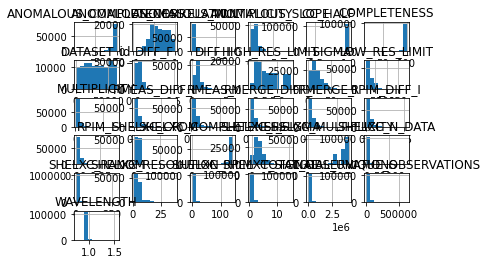

In [6]:
x.hist()
plt.show()

There are many features, so the layout might look constrained. The important observation is that most features appear to have **outliers**; some more significant than others, but they are there. For this reason, following the analysis we will also analyse the *median* of each feature, instead of just the *mean*, in order to reduce outlier influence.

## Correlation & Indicators

A correlation matrix was then used to identify initial correlation between elements. **Anomalous correlation** and the varius **completeness** metrics appear to usually have among the highest correlations, granting them special attention in the following analysis.

### New Data

With the new data and acl condition, **completeness** stopped having among the highest correlations with the target. **Shelx multiplicity** now has the highest correlation, followed by **anomalous correlation** and a few variations of **RPIM** and **RMEAS** (+ **SHELX RANOM**, **CC HALF** and surprisingly **dataset id**).

Both **high/low resolution limits** and **wavelength** have the lowest correlation, contradicting my initial thoughts.

A feature correlation matrix can also be created and analysed to see that many metrics have **very high inter-correlation**, especially if they are variations of the same one (e.g. RMEAS_I, RMEAS_DIFF_I, RMERGE_I, RMERGE_DIFF_I, RPIM_I, RPIM_DIFF_I, MULTIPLICITY, ANOMALOUS_MULTIPLICITY)

**Anomalous correlation** seems to be highly correlated with **anomalous slope** and **DIFF_I** (not as strong but also with **SHELX_SIGNAL/CFOM**). **SHELX multiplicity** isn't as inter-correlated as **AC**, but it is still mostly correlated with **(anomalous) completeness** and **SHELX completeness/n_data/resolution**.

In [7]:
corr_sorted = abs(x.corrwith(y)).sort_values(ascending=False)
print(corr_sorted)

SHELXC_MULTIPLICITY          0.023112
ANOMALOUS_CORRELATION        0.021795
RPIM_I                       0.019128
SHELXC_RPIM                  0.017797
SHELXC_RANOM                 0.017797
RPIM_DIFF_I                  0.017492
CC_HALF                      0.017255
DATASET_id                   0.016633
RMEAS_DIFF_I                 0.016076
RMEAS_I                      0.015923
MULTIPLICITY                 0.015281
TOTAL_OBSERVATIONS           0.014427
RMERGE_DIFF_I                0.014068
RMERGE_I                     0.013789
ANOMALOUS_MULTIPLICITY       0.013459
ANOMALOUS_COMPLETENESS       0.013103
SHELXC_COMPLETENESS          0.012711
SHELXC_N_DATA                0.011789
SHELXC_RESOLUTION            0.011094
DIFF_F                       0.010173
COMPLETENESS                 0.008628
SHELXC_CFOM                  0.008239
SHELXC_SIGNAL                0.008210
I_SIGMA                      0.007440
TOTAL_UNIQUE_OBSERVATIONS    0.006134
ANOMALOUS_SLOPE              0.005429
DIFF_I      

A union dataset, including both the features and labels in a single dataframe was created for convenience. It was then grouped by success status, and the summary statistics observed.

In [8]:
union = pd.concat([x.iloc[:, 2:], y], axis=1)
print(union.groupby("IS_SUCCESS").describe())

           HIGH_RES_LIMIT                                                   \
                    count      mean       std   min   25%   50%  75%   max   
IS_SUCCESS                                                                   
0.0               92516.0  3.691822  1.692585  0.91  2.35  3.45  5.0  7.06   
1.0               17493.0  3.696037  1.695042  0.91  2.33  3.50  5.0  7.05   

           LOW_RES_LIMIT            ... SHELXC_RANOM        SHELXC_SIGNAL  \
                   count      mean  ...          75%    max         count   
IS_SUCCESS                          ...                                     
0.0              92516.0  27.14479  ...        12.83  285.4       92516.0   
1.0              17493.0  27.18477  ...        12.26  285.4       17493.0   

                                                               
                mean       std   min   25%   50%   75%    max  
IS_SUCCESS                                                     
0.0         1.086301  0.564438 

Generally speaking, the *mean*, *std* and *median* of every metric is similar, and there doesn't seem to be an obvious outlier to serve as a success identifier. For a more quantitative analysis, the relative difference of the success/failure *mean* & *median* values of each metric was obtained and sorted.

In [9]:
grp_meds = union.groupby("IS_SUCCESS").agg(["mean", "median"])
rel_diff = abs(1 - grp_meds.iloc[1, :] / grp_meds.iloc[0, :])
rel_diff = rel_diff.sort_values(ascending=False)
print(rel_diff)

ANOMALOUS_CORRELATION      median    0.113636
                           mean      0.095067
TOTAL_OBSERVATIONS         mean      0.071536
SHELXC_RPIM                mean      0.069428
SHELXC_RANOM               mean      0.069425
LOW_RES_LIMIT              median    0.068313
SHELXC_N_DATA              mean      0.056046
ANOMALOUS_MULTIPLICITY     median    0.043478
SHELXC_N_DATA              median    0.041617
RPIM_DIFF_I                mean      0.039481
SHELXC_RESOLUTION          median    0.039216
RPIM_I                     mean      0.039051
RMEAS_DIFF_I               mean      0.034988
MULTIPLICITY               mean      0.033273
RMERGE_DIFF_I              mean      0.031350
ANOMALOUS_MULTIPLICITY     mean      0.029820
RMEAS_I                    mean      0.029713
I_SIGMA                    median    0.029070
TOTAL_UNIQUE_OBSERVATIONS  mean      0.026648
RMERGE_I                   mean      0.025992
SHELXC_RESOLUTION          mean      0.024052
MULTIPLICITY               median 

The first 4 represent signal-to-noise ratio and intensity/number of observations.

This last table presents a clearer success indicator: the **anomalous dispersion**. Both the *mean* & *median* of this metric have the highest relative difference for (un)successfull mapping. When using the whole dataset, the **high & low resolution limits**' median follow (unlike their *means*, which are on the low end of the table). Other interesting features are the number of **total observations**, **multiplicity**, and **anomalous multiplicity**, the metrics of which all appear to be on the high end of the table.

The **completeness metrics** are present lower on the table, opposing the initial thoughts of them being a good success indicator.

## Visualisation

**Visualisation** is an essential tool in understanding data. However, this dataset has a positive/negative label ratio of ~1/5, meaning that the **negative dominates**. Most color coded graphs are too clustered and dominated by the negative data to present any useful insight.

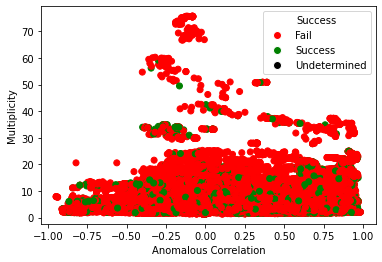

In [10]:
x_plot, y_plot = x["ANOMALOUS_CORRELATION"], x["MULTIPLICITY"]

fig, ax = plt.subplots()

cmap = {0: "red", 1: "green", np.nan: "black"}
ax.scatter(x_plot, y_plot, c=y.map(cmap))

ax.set_xlabel(x_plot.name.replace("_", " ").lower().title())
ax.set_ylabel(y_plot.name.replace("_", " ").lower().title())

# add a legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=v, label=k, markersize=8)
           for k, v in {"Fail": "red", "Success": "green", "Undetermined": "black"}.items()]
ax.legend(title="Success", handles=handles)

plt.show()

To solve this, I've thought of **truncating the negative data**, making it so there's the same amount of negative points as there is positive. This would of course result in a loss of information, but it should also reduce bias, if done randomly that is.

In [29]:
# reduce data to have same amount of positive/negative labels
n = np.count_nonzero(y)
lose = y == 0
lose_sample = y[lose].sample(n=n)
lose_sample_mask = lose_sample == 0
win = y == 1
win_sample = y[win].sample(n=n)
win_sample_mask = win_sample == 1

mask = y.astype(bool).copy()
mask.loc[:] = False
mask.update(lose_sample_mask)
mask.update(win_sample_mask)
x_redu, y_redu = x[mask], y[mask]

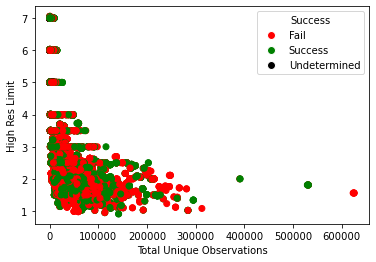

In [30]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier


# plot again
x_plot, y_plot = x_redu["TOTAL_UNIQUE_OBSERVATIONS"], x_redu["HIGH_RES_LIMIT"]

fig, ax = plt.subplots()

'''kn = 20
X = pd.concat([x_plot, y_plot], axis=1)
clf = KNeighborsClassifier(kn)
clf.fit(X, y_redu)

# grid and predict
step = .1
x_min, x_max = X.iloc[:, 0].min() - .2, X.iloc[:, 0].max() + .2
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step=step),
                     np.arange(y_min, y_max, step=step))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
'''
cmap = {0: "red", 1: "green", np.nan: "black"}
ax.scatter(x_plot, y_plot, c=y_redu.map(cmap))
#ax.contourf(xx, yy, Z, cmap=ListedColormap(["red", "green"]), alpha=.5)

ax.set_xlabel(x_plot.name.replace("_", " ").lower().title())
ax.set_ylabel(y_plot.name.replace("_", " ").lower().title())

# add a legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=v, label=k, markersize=8)
           for k, v in {"Fail": "red", "Success": "green", "Undetermined": "black"}.items()]
ax.legend(title="Success", handles=handles)

plt.show()

## Use space group, solvent content & number of sites. Group by wavelength, resolution limits. Also try PCA.

https://github.com/erdogant/pca